# Research of ads for the sale of apartments

Dataset is an archive of advertisements for the sale of apartments in St. Petersburg and neighboring settlements for several years. It is necessary to determine which factors most influence the market value of real estate.

# Columns:

* airports_nearest - distance to the nearest airport in meters (m)
* balcony — number of balconies
* ceiling_height - ceiling height (m)
* cityCenters_nearest - distance to the city center (m)
* days_exposition - how many days the ad was placed (from publication to removal)
* first_day_exposition - publication date
* floor - floor
* floors_total - total floors in the building
* is_apartment - apartments (boolean)
* kitchen_area - kitchen area in square meters (m²)
* last_price - price at the time of unpublishing
* living_area - living area in square meters (m²)
* locality_name — name of the locality
* open_plan - open plan (boolean)
* parks_around3000 - number of parks within a 3 km radius
* parks_nearest - distance to the nearest park (m)
* ponds_around3000 - the number of ponds within a radius of 3 km
* ponds_nearest — distance to the nearest body of water (m)
* rooms - number of rooms
* studio - studio apartment (boolean)
* total_area - area of the apartment in square meters (m²)
* total_images - the number of photos of the apartment in the ad

## Examining data from a file

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('real_estate_data.csv', sep='\t')
display(data.head())
display(data.info())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

None

### Conclusion
1. Of the 22 columns in the dataset, 14 contain gaps, and in some of them (is_apartment, parks_nearest, ponds_nearest) gaps make up most of the data.
To handle gaps, it will be possible to use the following methods: global median over the entire dataframe, median by groups, replace with 0, replace with False, delete rows with gaps.
2. The cityCenters_nearest column will need to be renamed.
3. Column types floors_total, balcony, parks_around3000, ponds_around3000, days_exposition should be replaced with an integer.

## Data preprocessing

In [3]:
# start handling gaps from the first column where they occur - ceiling_height
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()
data['ceiling_height'].head()

0    2.70
1    2.65
2    2.65
3    2.65
4    3.03
Name: ceiling_height, dtype: float64

In [4]:
data['ceiling_height'].isna().sum()

0

Since every apartment has a ceiling, and its height is approximately the same, filling in "0" would be incorrect. Delete lines with gaps too, because this column is missing about 40% of the data. As a result, it is filled with medians, throughout the dataset, excluding groups, because the height of ceilings in St. Petersburg differs upwards from the average value only in a small number of houses of the old fanda in the city center.

In [5]:
#rows with empty values in floors_total can be deleted, because their share in the dataset is only 0.4%
data = data.dropna(subset=['floors_total'])
data['floors_total'].isna().sum()

0

In [6]:
# in the living area column, you can replace gaps with medians grouped by the number of rooms
for rooms in data['rooms'].unique(): 
    median = data.loc[data['rooms'] == rooms, 'living_area'].median()
    data.loc[(data['living_area'].isna()) & (data['rooms'] == rooms), 'living_area'] = median
data['living_area'].isna().sum()

0

Gaps in column is_apartment needs to be replaced with False, as gaps are most likely where the type is not an apartment, it's just not specified.

In [7]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'].value_counts()

False    23563
True        50
Name: is_apartment, dtype: int64

In [8]:
# gaps in kitchen_area replace with median values
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data['kitchen_area'].median()
data['kitchen_area'].head()
data['kitchen_area'].isna().sum()

0

Gaps in balconies should probably be replaced with 0, if there is no information about them, then there are probably no balconies.

In [9]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].isna().sum()

0

Lines with gaps in locality_name will be deleted, because there are few gaps, and there is no existing correct way of processing

In [10]:
data = data.dropna(subset=['locality_name'])
data['locality_name'].isna().sum()

0

In [11]:
data.loc[data['airports_nearest'].isna(), 'airports_nearest'] = data['airports_nearest'].median()
data['airports_nearest'].isna().sum()

0

In [12]:
data.loc[data['cityCenters_nearest'].isna(), 'cityCenters_nearest'] = data['cityCenters_nearest'].median()
data['cityCenters_nearest'].isna().sum()

0

In [13]:
data.loc[data['parks_around3000'].isna(), 'parks_around3000'] = data['parks_around3000'].median()
data.loc[data['parks_nearest'].isna(), 'parks_nearest'] = data['parks_nearest'].median()
data.loc[data['ponds_around3000'].isna(), 'ponds_around3000'] = data['ponds_around3000'].median()
data.loc[data['ponds_nearest'].isna(), 'ponds_nearest'] = data['ponds_nearest'].median()
data.loc[data['days_exposition'].isna(), 'days_exposition'] = data['days_exposition'].fillna(0)
data.isna().sum()

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  bool   
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

All gaps in the dataframe are processed, in the days_exposition column we also had to replace the gaps with medians, because this is necessary for further elimination of outliers. However, I think the replacement in this column is not entirely correct, since this column shows the number of days from publication to removal, the absence of a value in the column may indicate that the announcement has not yet been removed.

Column values: floors_total, balcony, parks_around3000, ponds_around3000 - must be integer, so it is necessary to change the data type.

In [15]:
data['floors_total'] = data['floors_total'].astype('int64')
data['balcony'] = data['balcony'].astype('int64')
data['parks_around3000'] = data['parks_around3000'].astype('int64')
data['ponds_around3000'] = data['ponds_around3000'].astype('int64')

The last thing I would like to do in preprocessing is to change the name of the cityCenters_nearest column.

In [16]:
data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'}, inplace=True)

## Calculations and adding results to the table

Add a new column with price per square meter.

In [17]:
data['price_for_metre'] = data['last_price'] / data['total_area']
data['price_for_metre'].head()

0    120370.370370
1     82920.792079
2     92785.714286
3    408176.100629
4    100000.000000
Name: price_for_metre, dtype: float64

Add a column with the day of the week the announcement was published, first you need to convert the column into a format for working with date and time.

In [18]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['week_day_exp'] = data['first_day_exposition'].dt.weekday
data['week_day_exp'].head(3)

0    3
1    1
2    3
Name: week_day_exp, dtype: int64

Add a column with the month of publication of the ad.

In [19]:
data['month_exp'] = data['first_day_exposition'].dt.month
data['month_exp'].head(3)

0     3
1    12
2     8
Name: month_exp, dtype: int64

Add a column with the year of publication of the announcement.

In [20]:
data['year_exp'] = data['first_day_exposition'].dt.year
data['year_exp'].head(3)

0    2019
1    2018
2    2015
Name: year_exp, dtype: int64

Add a column with the apartment floor option: first, last, other.

In [21]:
data.loc[data['floor'] == 1, 'floor_type'] = 'first'
data.loc[~ (data['floor_type'] == 'first') & (data['floor'] == data['floors_total']), 'floor_type'] = 'last'
data.loc[~ (data['floor_type'] == 'first') & ~(data['floor_type'] == 'last'), 'floor_type'] = 'other'
data['floor_type'].value_counts()

other    17326
last      3330
first     2909
Name: floor_type, dtype: int64

Сolumn with the ratio of residential and total area:

In [22]:
data['living_area_rate'] = data['living_area'] / data['total_area']
data['living_area_rate'].head(3)

0    0.472222
1    0.460396
2    0.612500
Name: living_area_rate, dtype: float64

Сolumn with the ratio of kitchen area to total:

In [23]:
data['kitchen_area_rate'] = data['kitchen_area'] / data['total_area']
data['kitchen_area_rate'].head(3)

0    0.231481
1    0.272277
2    0.148214
Name: kitchen_area_rate, dtype: float64

Histogram for price per square meter.

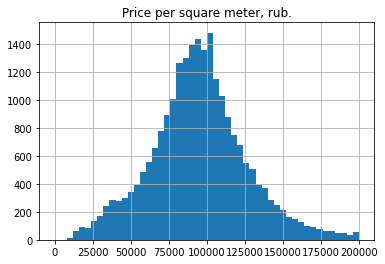

In [24]:
data['price_for_metre'].hist(bins=50, range=(0, 200000)).set_title("Price per square meter, rub.");

Histogram for area parameter.

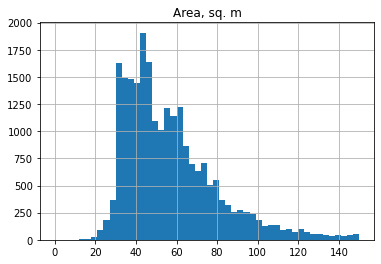

In [25]:
data['total_area'].hist(bins=50, range=(0, 150)).set_title("Area, sq. m");

In [26]:
data['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

Histogram for the number of rooms.

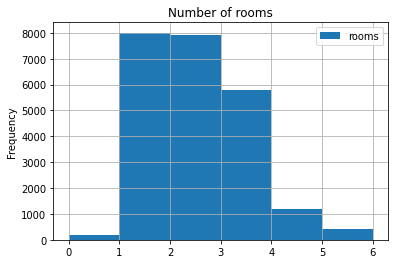

In [27]:
data.plot(kind = 'hist', y = 'rooms', bins=6, grid = True, range=(0, 6)).set_title("Number of rooms");

Histogram for ceiling height.

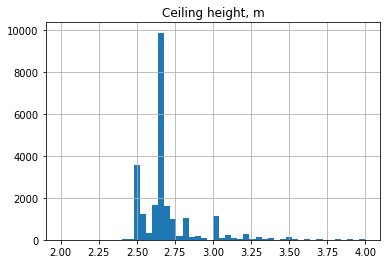

In [28]:
data['ceiling_height'].hist(bins=50, range=(2, 4)).set_title("Ceiling height, m");

Histogram for apartment sale time.

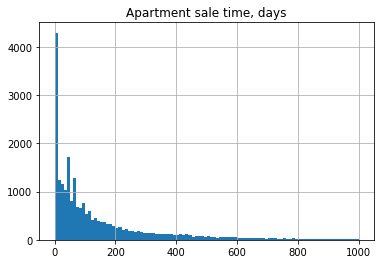

In [29]:
data['days_exposition'].hist(bins=100, range=(0, 1000)).set_title("Apartment sale time, days");

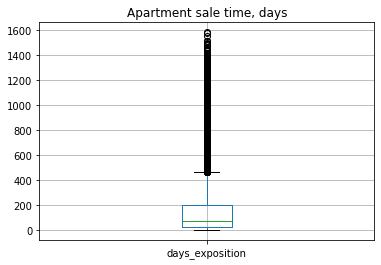

In [30]:
data.boxplot(column=['days_exposition']).set_title("Apartment sale time, days");

The boxplot shows that there are a lot of outliers (everything above 440 days).

In [31]:
data['days_exposition'].describe()

count    23565.000000
mean       156.420115
std        213.517293
min          0.000000
25%         22.000000
50%         73.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

**Conclusion:** 

Usually the sale takes 95 days. From 1 to 45 days - means a quick sale, values more than 400 - unusually long.
The mean (156) is twice the median, which means there is a tail with high values that strongly influences the mean.

## Exploratory data analysis

Calculate the boundaries of the interval of the most probable values.

iqr for total_area

In [32]:
q1 = data['total_area'].quantile(0.25)
q3 = data['total_area'].quantile(0.75)
iqr = q3 - q1
total_area_iqr = q3 + 1.5 * iqr
total_area_iqr

114.25

In [33]:
#iqr for rooms
q1 = data['rooms'].quantile(0.25)
q3 = data['rooms'].quantile(0.75)
iqr = q3 - q1
total_area_iqr = q3 + 1.5 * iqr
total_area_iqr

6.0

In [34]:
#iqr for price_for_metre
q1 = data['price_for_metre'].quantile(0.25)
q3 = data['price_for_metre'].quantile(0.75)
iqr = q3 - q1
total_area_iqr = q3 + 1.5 * iqr
total_area_iqr

170683.80698882308

In [35]:
#iqr for ceiling_height
q1 = data['ceiling_height'].quantile(0.25)
q3 = data['ceiling_height'].quantile(0.75)
iqr = q3 - q1
total_area_iqr = q3 + 1.5 * iqr
total_area_iqr

2.8500000000000005

In [36]:
#iqr for days_exposition
q1 = data['days_exposition'].quantile(0.25)
q3 = data['days_exposition'].quantile(0.75)
iqr = q3 - q1
total_area_iqr = q3 + 1.5 * iqr
total_area_iqr

462.0

Remove rare and abnormally large values from the dataset.

In [37]:
data_new = data.query('12 < total_area < 115 and 20000 < price_for_metre < 171000 and 1 < rooms < 6 and 2.4 < ceiling_height < 3 and days_exposition < 462')

In [38]:
data_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11088 entries, 0 to 23696
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          11088 non-null  int64         
 1   last_price            11088 non-null  float64       
 2   total_area            11088 non-null  float64       
 3   first_day_exposition  11088 non-null  datetime64[ns]
 4   rooms                 11088 non-null  int64         
 5   ceiling_height        11088 non-null  float64       
 6   floors_total          11088 non-null  int64         
 7   living_area           11088 non-null  float64       
 8   floor                 11088 non-null  int64         
 9   is_apartment          11088 non-null  bool          
 10  studio                11088 non-null  bool          
 11  open_plan             11088 non-null  bool          
 12  kitchen_area          11088 non-null  float64       
 13  balcony         

**Conclusion:**

By calculating the limits of outlines for each of the parameters, the boundaries of the intervals of the most probable values were found. Having fulfilled all the necessary conditions using the query method, the values in data_new were halved relative to the original data, but the selection became more representative.

Invistigate what factors most affect the cost of an apartment.

Start from area factor

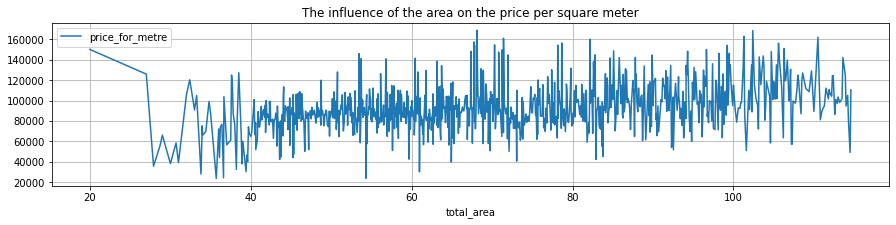

In [39]:
data_new.groupby('total_area').agg({'price_for_metre': 'median'}).plot(grid=True, figsize=(15,3)).set_title("The influence of the area on the price per square meter");

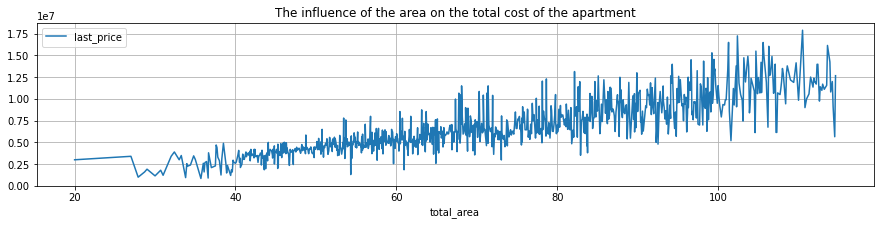

In [40]:
data_new.groupby('total_area').agg({'last_price': 'median'}).plot(grid=True, figsize=(15,3)).set_title("The influence of the area on the total cost of the apartment");

In [41]:
data_new['price_for_metre'].corr(data_new['total_area'])

0.21295617892982166

In [42]:
data_new['last_price'].corr(data_new['total_area'])

0.718841508724494

Based on the graphs obtained and the correlation value, it can be seen that the area of the apartment has a low effect on the price per square meter, but the area has a strong effect on the total cost of the apartment.

Parametr: number of rooms.

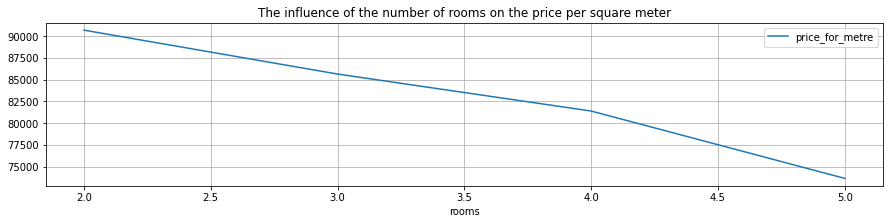

In [43]:
data_new.groupby('rooms').agg({'price_for_metre': 'median'}).plot(grid=True, figsize=(15,3)).set_title("The influence of the number of rooms on the price per square meter");

In [44]:
data_new['price_for_metre'].corr(data_new['rooms'])

-0.07743408960165273

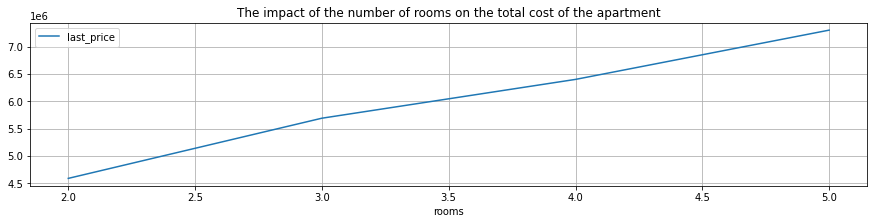

In [45]:
data_new.groupby('rooms').agg({'last_price': 'median'}).plot(grid=True, figsize=(15,3)).set_title("The impact of the number of rooms on the total cost of the apartment");

The price per square meter is higher in apartments with a small number of rooms, while at the same time, with an increase in the number of rooms, the total cost of the apartment increases.

Distance factor from the center.

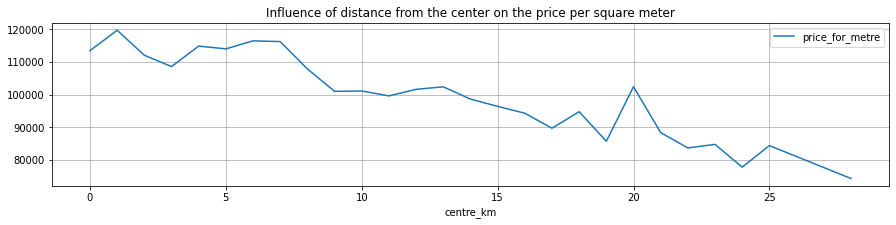

In [46]:
data_new['centre_km'] = data_new['city_centers_nearest'] // 1000

data_new.query('locality_name == "Санкт-Петербург"').groupby('centre_km').agg({'price_for_metre': 'mean'}).plot(grid=True, figsize=(15,3)).set_title("Influence of distance from the center on the price per square meter");

In [47]:
data_new['price_for_metre'].corr(data_new['city_centers_nearest'])

-0.18735544786408723

The graph shows a clear influence of the distance of the apartment from the center on the price per square meter. The closer to the center, the higher the price.

Factor of location of the apartment on the floor: first / last / other.

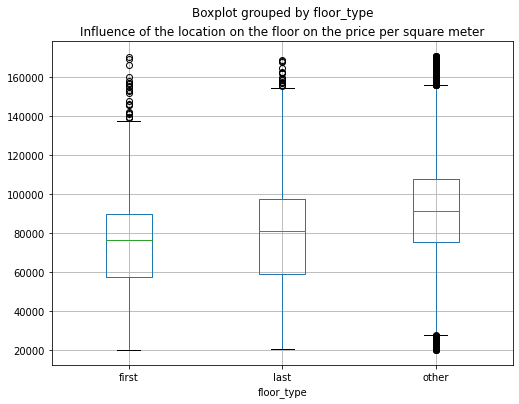

In [48]:
data_new.boxplot(column='price_for_metre', by='floor_type', figsize=(8,6)).set_title("Influence of the location on the floor on the price per square meter");

The highest price of an apartment on a floor different from the first and last. The lowest price for an apartment on the first floor.

Influence on the price of the placement date: day of the week, month, year.

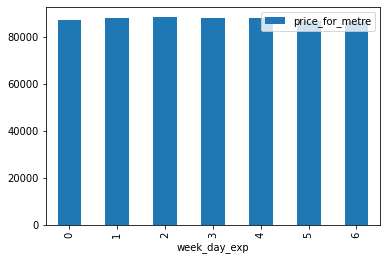

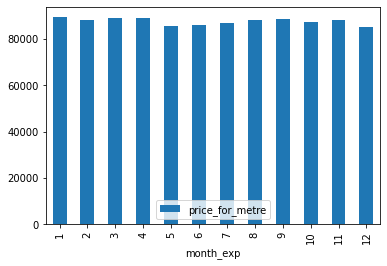

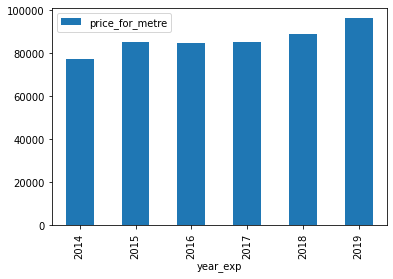

In [49]:
date_list = ['week_day_exp', 'month_exp', 'year_exp']
for period in date_list:
    data_new.pivot_table(index=period,values = 'price_for_metre', aggfunc = 'median').plot(kind='bar')
    plt.show()

The graphs show that the price per square meter does not depend on the day of the week, but the more current the year, the higher the price.

Analysis of 10 settlements with the largest number of ads (because we are looking for the largest number of ads - we take the original table).

In [50]:
top_10_location = data['locality_name'].value_counts().head(10).index.values
top_10_location

array(['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары',
       'Всеволожск', 'Пушкин', 'Колпино', 'посёлок Парголово', 'Гатчина',
       'деревня Кудрово', 'Выборг'], dtype=object)

In [51]:
data[data['locality_name'].isin(top_10_location)].groupby('locality_name').agg({'price_for_metre':'mean'}).sort_values('price_for_metre', ascending=False)

,price_for_metre
locality_name,
Санкт-Петербург,114868.877341
Пушкин,103125.819291
деревня Кудрово,92473.547576
посёлок Парголово,90175.913458
посёлок Мурино,85673.259928
посёлок Шушары,78551.344545
Колпино,75424.579098
Гатчина,68746.146763
Всеволожск,68654.473986


The highest price per square meter obviously is in St. Petersburg itself, the price per square meter in Vyborg is almost two times lower, which is probably due to the fact that Vyborg is the farthest of all settlements.

Analysis of price changes by degree of distance from the center.

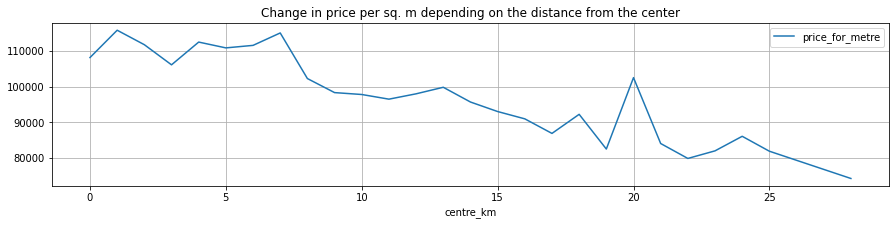

In [52]:
data_new.query('locality_name == "Санкт-Петербург"').groupby('centre_km').agg({'price_for_metre':'median'}).plot(grid=True, figsize=(15,3)).set_title("Change in price per sq. m depending on the distance from the center");

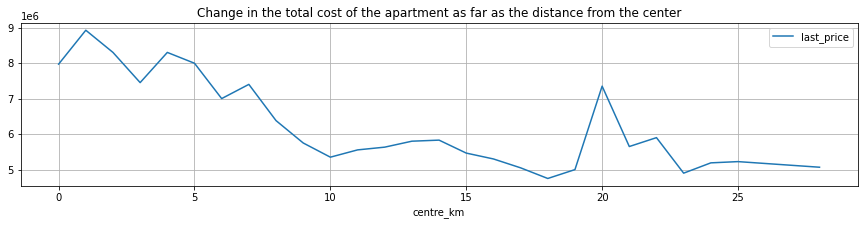

In [53]:
data_new.query('locality_name == "Санкт-Петербург"').groupby('centre_km').agg({'last_price':'median'}).plot(grid=True, figsize=(15,3)).set_title("Change in the total cost of the apartment as far as the distance from the center");

Both graphs show that at a distance of about 6 km from the center - the price per meter / total cost of the apartment starts to decrease, so we will assume that the central zone is within 6 km.

Research of parameters for apartments in the center (remoteness no more than 6 km).

Histogram for price per square meter.

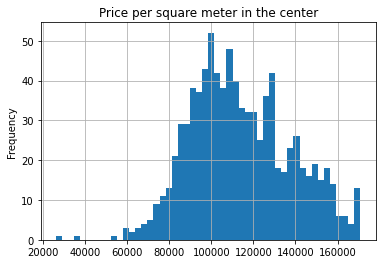

In [54]:
data_new.query('centre_km <= 6')['price_for_metre'].plot(kind='hist', bins=50, grid = True).set_title("Price per square meter in the center");

Histogram for area parameter.

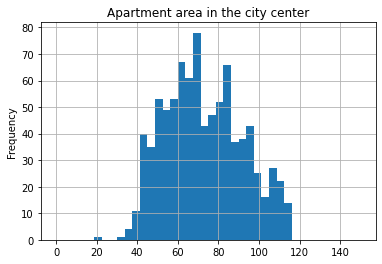

In [55]:
data_new.query('centre_km <= 6')['total_area'].plot(kind='hist', bins=40, grid = True, range=(0, 150)).set_title("Apartment area in the city center");

Histogram for the number of rooms.

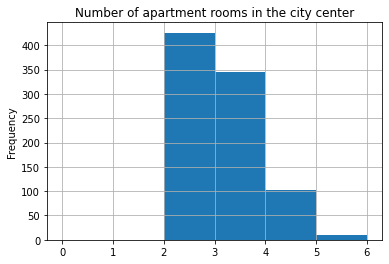

In [56]:
data_new.query('centre_km <= 6')['rooms'].plot(kind = 'hist', bins=6, grid = True, range=(0, 6)).set_title("Number of apartment rooms in the city center");

Histogram for ceiling height.

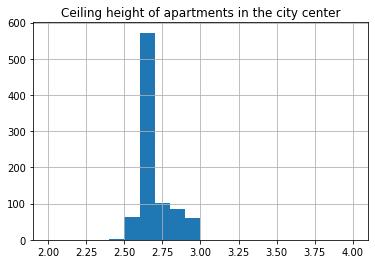

In [57]:
data_new.query('centre_km <= 6')['ceiling_height'].hist(bins=20, range=(2, 4)).set_title("Ceiling height of apartments in the city center");

Histogram for apartment sale time.

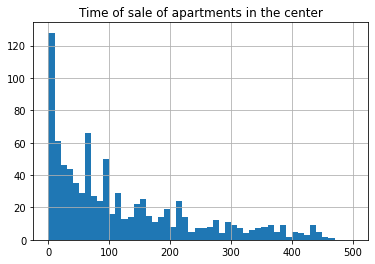

In [58]:
data_new.query('centre_km <= 6')['days_exposition'].hist(bins=50, range=(0, 500)).set_title("Time of sale of apartments in the center");

**Conclusion:**

The factor that most distinguishes apartments in the center is the price per square meter. If in the general sample the price starts from 25k rub per meter, then in the center - from 60 k rub. Also, in the center of the apartment in the filtered sample, they start with two-room apartments, the total area of apartments is larger, but the ceiling height practically does not differ from the general sample.

## General conclusion

As part of the project, first of all, all gaps that were in more than half of the columns were processed. The intervals of the most probable values ​​for each of the parameters, and the factors that most affect the price are determined:
* the area of the apartment and the number of rooms greatly affect the total cost of the apartment and less on the price per square meter
* Significantly influencing factor - distance from the city center; in addition, the settlements with the highest and lowest prices were identified (St. Petersburg and Vyborg, respectively)
* the location of the apartment on the floor is also a significant factor: not the first and not the last floor increase the price of the apartment per square meter, the apartments on the first floor are the cheapest.

The price per square meter in the city center is much higher than in the general sample, there are no apartments cheaper than about 60k rub per square meter, the area and the number of rooms in apartments in the city center are on average larger.